In [16]:
from IPython.core.display import HTML, display

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as pl
from matplotlib import rcParams

from keras import models
from keras import layers

from tqdm import tnrange, tqdm_notebook

In [4]:
% matplotlib inline
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20

In [5]:
df_chl = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_noInteractions.pkl')

In [6]:
df_chl.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [8]:
X = df_chl.dropna().loc[:, 'sin_doy': 'PC6_s'].values
y = df_chl.dropna().log10_chl.values

In [10]:
assert X.shape[0] == y.size

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

def smooth(curve, points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

Given the small size of the data set, I will use k-fold validation to train the model.

In [19]:
k = 4
num_val_samples = X_train.shape[0] // k
num_epochs = 100
all_scores = []
for i in tqdm_notebook(range(k), desc='k-fold loop'):
    val_beg_idx, val_end_idx = i * num_val_samples, (i + 1) * num_val_samples
    X_val = X_train[val_beg_idx: val_end_idx]
    y_val = y_train[val_beg_idx: val_end_idx]
    X_partial_train = np.concatenate([X_train[:val_beg_idx],X_train[val_end_idx:]],
                                    axis=0)
    y_partial_train = np.concatenate([y_train[:val_beg_idx], y_train[val_end_idx:]],
                                    axis=0)
    
    model = build_model()
    history = model.fit(X_partial_train, y_partial_train, epochs=num_epochs,
                        batch_size=1, verbose=0)
    val_mse, val_mae= model.evaluate(X_val, y_val, verbose=0)
    all_scores.append(val_mae)

In [20]:
all_scores

[0.15956789657876297,
 0.15286120127987218,
 0.1691807979667509,
 0.23525612740903287]

In [21]:
np.mean(all_scores)

0.17921650580860474

In [22]:
k = 4
num_val_samples = X_train.shape[0] // k
num_epochs = 500
all_mae_histories = []
for i in tqdm_notebook(range(k), desc='k-fold loop'):
    val_beg_idx, val_end_idx = i * num_val_samples, (i + 1) * num_val_samples
    X_val = X_train[val_beg_idx: val_end_idx]
    y_val = y_train[val_beg_idx: val_end_idx]
    X_partial_train = np.concatenate([X_train[:val_beg_idx],X_train[val_end_idx:]],
                                    axis=0)
    y_partial_train = np.concatenate([y_train[:val_beg_idx], y_train[val_end_idx:]],
                                    axis=0)
    
    model = build_model()
    history = model.fit(X_partial_train, y_partial_train, epochs=num_epochs,
                        validation_data=(X_val, y_val),
                        batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

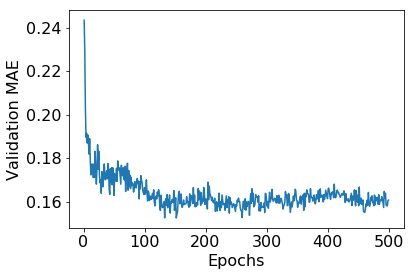

In [25]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                       for i in range(num_epochs)]
pl.plot(range(1, len(average_mae_history) + 1), average_mae_history)
pl.xlabel('Epochs')
pl.ylabel('Validation MAE');

In [26]:
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

127/127 [==============================] - 0s 29us/step


In [28]:
np.sqrt(test_mse_score)

0.26355925229814564

In [29]:
test_mae_score

0.18035603602101483

In [ ]:
from sklearn.metrics import mean_absolute_error